In [205]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from sklearn.decomposition import PCA

from sklearn.neighbors import KernelDensity

Preparing the Data

In [139]:
df_curve = pd.read_csv('https://goz39a.s3.eu-central-1.amazonaws.com/Yield.csv')
df_curve.head()

,T,1Y,2Y,3Y,4Y,5Y,7Y,10Y,30Y
0,2001-01-02,4.692,4.5650,4.6550,4.7550,4.870,5.102,5.345,5.742
1,2001-01-03,4.619,4.5715,4.6550,4.7600,4.870,5.089,5.306,5.716
2,2001-01-04,4.526,4.5350,4.6650,4.7725,4.885,5.103,5.324,5.734
3,2001-01-05,4.458,4.4588,4.5888,4.7138,4.830,5.046,5.278,5.703
4,2001-01-08,4.451,4.4738,4.5850,4.7050,4.830,5.050,5.264,5.694


In [140]:
df_curve.set_index('T',inplace=True)
tenors = df_curve.columns

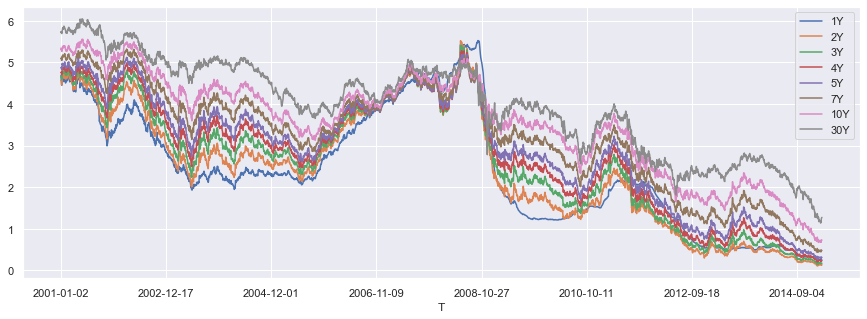

In [141]:
df_curve.plot(figsize=(15,5));

The curves above illustrate the fact that interest rates have meen going down across all the different tenors.<br>
We can observe the following particular movements :
- Dec 20, 2001 to Mar 17, 2003 : Parallel (downward) shift
- Mar 17, 2003 to Dec 19, 2005 : Flattening of the curve & downward shift
- Dec 19, 2005 to Dec 17,2008 : Curvature change

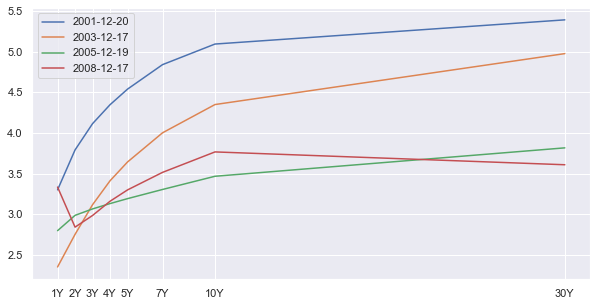

In [142]:
dates = ['2001-12-20','2003-12-17','2005-12-19','2008-12-17']
fix,ax = plt.subplots(1,1,figsize=(10,5))
for d in dates:
    curve_on_day = df_curve.loc[d,:]
    x_ticks = [np.float(x.split('Y')[0]) for x in np.array(df_curve.columns.values)]
    ax.plot(x_ticks,curve_on_day.values,label=d)


ax.set_xticks(x_ticks)
ax.set_xticklabels(np.array(df_curve.columns.values));
ax.legend();

We only have an interest in the daily change of the interest rates $r_{t}-r_{t-1}$

In [143]:
df_curve = df_curve.diff()

In [144]:
df_curve.dropna(how='any',inplace=True)
dr = df_curve.values
t = df_curve.index

Principal Components

In [145]:
pca = PCA()
pca.fit(dr)

PCA()

The `pca` model has different attributes after applying the fit() method on the dataset:
- `components_`
Principal axes in feature space, representing the directions of maximum variance in the data. The components are sorted by explained_variance_.

- `explained_variance_`
The amount of variance explained by each of the selected components.

- `explained_variance_ratio_`

Contribution of the different components

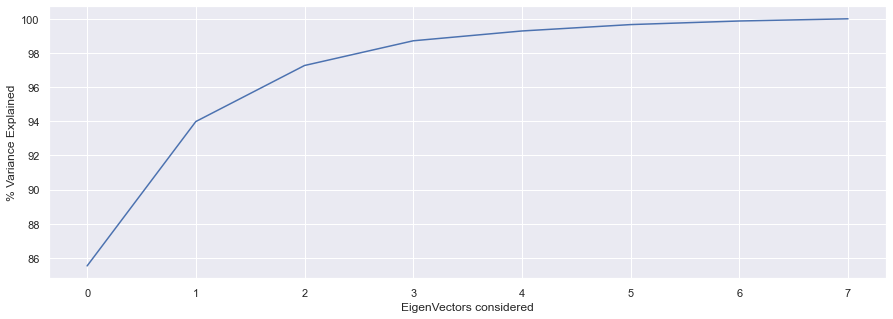

In [146]:
fig,ax = plt.subplots(1,1,figsize=(15,5))
ax.plot(np.arange(0,len(df_curve.columns)),100*np.cumsum(pca.explained_variance_ratio_));
ax.set_ylabel('% Variance Explained')
ax.set_xlabel('EigenVectors considered');

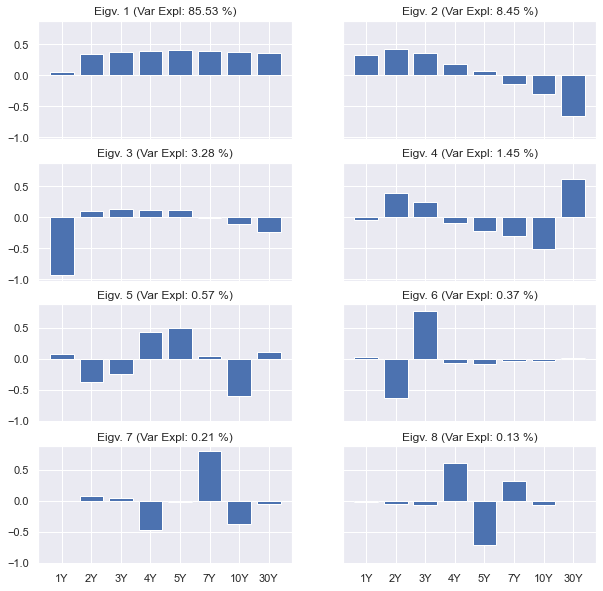

In [147]:
fig,ax = plt.subplots(4,2,figsize=(10,10),sharex=True,sharey=True)

i=0
for r in np.arange(0,4):
    for k in np.arange(0,2):
        ax[r,k].bar(x=np.arange(0,pca.components_.shape[0]),height= pca.components_[i,:]);
        ax[r,k].set_title('Eigv. '+str(i+1)+ ' (Var Expl: ' + str(np.round(pca.explained_variance_ratio_[i]*100,2))+' %)')
        ax[r,k].set_xticks(np.arange(0,pca.components_.shape[0]))
        ax[r,k].set_xticklabels(tenors)
        
        i+=1


Our attention goes to the first and second principal components. To study this, we are limiting the 8-D interest rate space to a 2-D space. Here we project the 1st and 2nd eigenvector on the 2D plane denoted by the 2 and 10 Yr interest rate

In [148]:
ix_2 = tenors=='2Y'
ix = np.arange(0,len(tenors))
ix_2= ix[np.where(ix_2)][0]

ix_10 = tenors=='10Y'
ix = np.arange(0,len(tenors))
ix_10= ix[np.where(ix_10)][0]

In [149]:
df_components = pd.DataFrame(pca.components_[0:2,[ix_2,ix_10]])
df_components.columns = ['2Y','10Y']
df_components

,2Y,10Y
0,0.336599,0.370448
1,0.430373,-0.304509


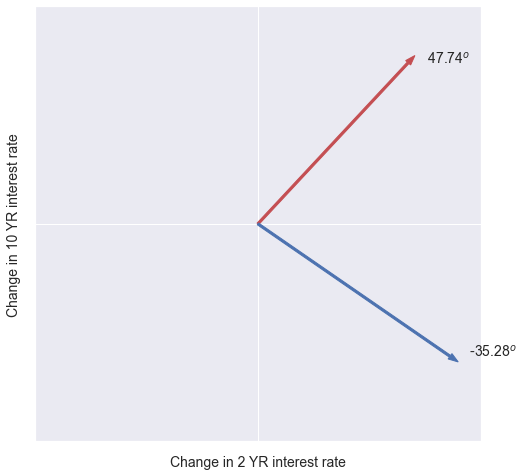

In [150]:
fig,ax = plt.subplots(1,1,figsize=(8,8),sharex=True,sharey=True)


ax.arrow(0, 0, pca.components_[0,ix_2],pca.components_[0,ix_10],color='r',width=.005)
ax.arrow(0, 0, pca.components_[1,ix_2],pca.components_[1,ix_10],color='b',width=.005)
ax.set_xticks([0])
ax.set_yticks([0])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlim([-0.5,0.5])
ax.set_ylim([-0.5,0.5])
ax.set_xlabel('Change in 2 YR interest rate',fontsize=14)
ax.set_ylabel('Change in 10 YR interest rate',fontsize=14)

angle = np.zeros(2)
angle[0] = np.round(np.arctan(pca.components_[0,ix_10]/pca.components_[0,ix_2])*180/np.pi,2)
angle[1] = np.round(np.arctan(pca.components_[1,ix_10]/pca.components_[1,ix_2])*180/np.pi,2)
ax.text(pca.components_[0,ix_2],pca.components_[0,ix_10],'     ' + str(angle[0]) + '$ ^{o}$',fontsize=14);
ax.text(pca.components_[1,ix_2],pca.components_[1,ix_10],'     ' + str(angle[1]) + '$ ^{o}$',fontsize=14);

We can extend the same intuition to the third eigenvector. The coordinates of this 3rd eigenvector in the domain of all our tenors, can be visualised:

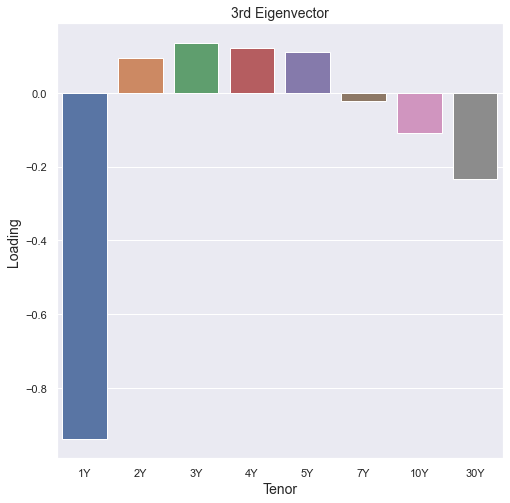

In [151]:
df_3_eigv = pd.DataFrame(data=pca.components_[2])
df_3_eigv.columns = ['loading']
df_3_eigv['tenor']=tenors

fig,ax = plt.subplots(1,1,figsize=(8,8),sharex=True,sharey=True)
sns.barplot(x='tenor',y='loading',data=df_3_eigv);
ax.set_xlabel('Tenor',fontsize=14)
ax.set_ylabel('Loading',fontsize=14);
ax.set_title('3rd Eigenvector',fontsize=14);

With the previous knowlegde we are going to reduce the dimension of the dataset from 8 to 2. This can be achieve making use of the two principal components (parallel shift and steepening/flattening)

In [152]:
pca_12 = PCA(n_components=2)
pca_12.fit(dr)

PCA(n_components=2)

In [160]:
Z=pd.DataFrame(pca_12.transform(dr))
Z.index = pd.to_datetime(t)
Z.columns = ['first','second']
Z.head()

,first,second
T,,
2001-01-03,-0.024690,0.010780
2001-01-04,0.020056,-0.058117
2001-01-05,-0.150572,-0.054646
2001-01-08,-0.003659,0.011082
2001-01-09,0.181376,0.058365


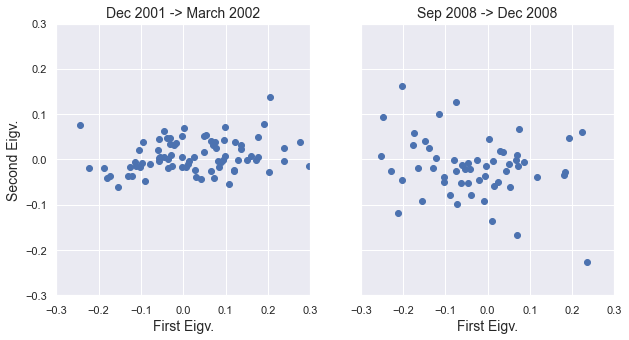

In [188]:
fig,ax = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)

idx_1 = (Z.index<pd.to_datetime('2002-04-01'))&( Z.index>pd.to_datetime('2001-12-01'))
idx_2 = (Z.index<pd.to_datetime('2008-12-01'))&( Z.index>pd.to_datetime('2008-09-01'))

ax[0].scatter(Z.loc[idx_1,'first'],Z.loc[idx_1,'second'])
ax[1].scatter(Z.loc[idx_2,'first'],Z.loc[idx_2,'second'])
ax[0].set_xlim([-0.3,0.3])
ax[0].set_ylim([-0.3,0.3])
ax[0].set_xlabel('First Eigv.',fontsize=14)
ax[1].set_xlabel('First Eigv.',fontsize=14)
ax[0].set_ylabel('Second Eigv.',fontsize=14)
ax[0].set_title('Dec 2001 -> March 2002',fontsize=14)
ax[1].set_title('Sep 2008 -> Dec 2008',fontsize=14);

We can now reconstruct the time-series bases on the most important components

In [201]:
pca_12.fit(dr)
Z = pca_12.transform(dr)
dr_z=pca_12.inverse_transform(Z)

Text(0.5, 1.0, '5 Year interest rate')

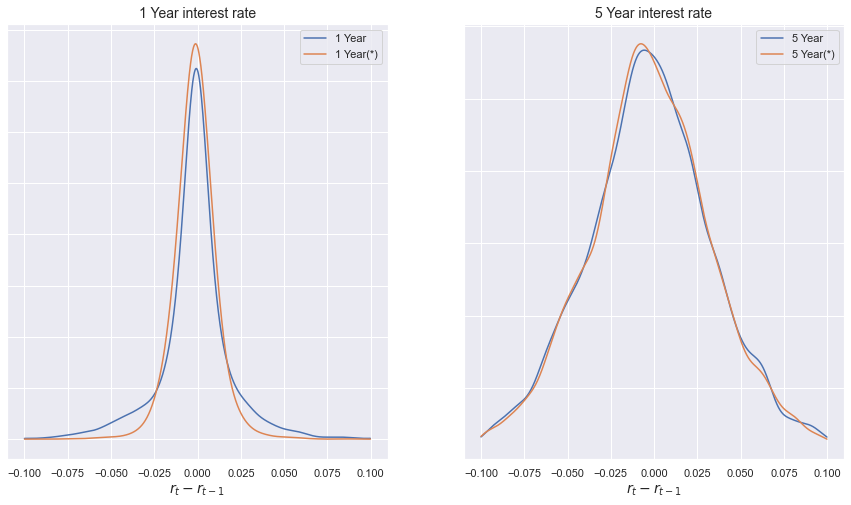

In [238]:
r = np.arange(-0.1,0.1,0.0001)
fig,ax = plt.subplots(1,2,figsize=(15,8))

# 1 year interest rate
bw=0.005
kernel_X = KernelDensity(kernel='gaussian',bandwidth=bw)
kernel_X.fit(dr[:,0].reshape(-1,1))
X_predict = np.exp(kernel_X.score_samples(r.reshape(-1,1)))
    
kernel_Z = KernelDensity(kernel='gaussian',bandwidth=bw)
kernel_Z.fit(dr_z[:,0].reshape(-1,1))
Z_predict = np.exp(kernel_Z.score_samples(r.reshape(-1,1)))
    
    
ax[0].plot(r,X_predict,label='1 Year')
ax[0].plot(r,Z_predict,label='1 Year(*)')
ax[0].legend()
ax[0].set_yticklabels([])
ax[0].set_xlabel('$r_{t}-r_{t-1}$',fontsize=14)
ax[0].set_title('1 Year interest rate',fontsize=14)


# 5 year interest rate
bw=0.005
kernel_X = KernelDensity(kernel='gaussian',bandwidth=bw)
kernel_X.fit(dr[:,4].reshape(-1,1))
X_predict = np.exp(kernel_X.score_samples(r.reshape(-1,1)))
    
kernel_Z = KernelDensity(kernel='gaussian',bandwidth=bw)
kernel_Z.fit(dr_z[:,4].reshape(-1,1))
Z_predict = np.exp(kernel_Z.score_samples(r.reshape(-1,1)))
    
    
ax[1].plot(r,X_predict,label='5 Year')
ax[1].plot(r,Z_predict,label='5 Year(*)')
ax[1].legend()
ax[1].set_yticklabels([])
ax[1].set_xlabel('$r_{t}-r_{t-1}$',fontsize=14)
ax[1].set_title('5 Year interest rate',fontsize=14);

In [203]:
np.std(dr,axis=0)

array([0.02288552, 0.03921927, 0.04261921, 0.04288364, 0.0436736 ,
       0.04225582, 0.04155318, 0.04443307])

In [204]:
np.std(dr_z,axis=0)

array([0.01201445, 0.03841666, 0.04200556, 0.04247549, 0.04318829,
       0.04181399, 0.04051851, 0.04334139])

In [218]:
r.reshape(-1,1)

array([[-1.00000000e-02],
       [-9.90000000e-03],
       [-9.80000000e-03],
       [-9.70000000e-03],
       [-9.60000000e-03],
       [-9.50000000e-03],
       [-9.40000000e-03],
       [-9.30000000e-03],
       [-9.20000000e-03],
       [-9.10000000e-03],
       [-9.00000000e-03],
       [-8.90000000e-03],
       [-8.80000000e-03],
       [-8.70000000e-03],
       [-8.60000000e-03],
       [-8.50000000e-03],
       [-8.40000000e-03],
       [-8.30000000e-03],
       [-8.20000000e-03],
       [-8.10000000e-03],
       [-8.00000000e-03],
       [-7.90000000e-03],
       [-7.80000000e-03],
       [-7.70000000e-03],
       [-7.60000000e-03],
       [-7.50000000e-03],
       [-7.40000000e-03],
       [-7.30000000e-03],
       [-7.20000000e-03],
       [-7.10000000e-03],
       [-7.00000000e-03],
       [-6.90000000e-03],
       [-6.80000000e-03],
       [-6.70000000e-03],
       [-6.60000000e-03],
       [-6.50000000e-03],
       [-6.40000000e-03],
       [-6.30000000e-03],
       [-6.2